In [127]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from numpy import conj, real, imag, cos, sin, exp, sqrt as conj, real, imag, cos, sin, exp, sqrt


In [128]:
# helper:
"""
cdef extern from "<complex.h>" namespace "std":
    double real(double complex z) nogil
    double complex conj(double complex z) nogil
    double imag(double complex z) nogil
    double abs(double complex z) nogil
cdef extern from "<math.h>" nogil:
    double pow(double r, double e)
    double exp(double r)
    double sqrt(double r)
"""

def calc_magnetization(psi, energies, Ny, beta, s_out):#cdef void calc_magnetization(double complex [:, :, :] psi, double [:,:] energies, int Ny, double beta, double [:,:] s_out) nogil:
    xi=0
    yi=1
    zi=2

    coeff = 1.0/Ny

    #Init loops
    for ii in range(s_out.shape[0]):
        s_out[ii, xi] = 0.0
        s_out[ii, yi] = 0.0
        s_out[ii, zi] = 0.0

    # Calculation loops
    for ki in range(energies.shape[1]):
        sk = 1.0
        if ki == 0 or (ki==(energies.shape[1]-1) and Ny%2 == 0):
            sk = 0.0
        for ni in range(energies.shape[0]):
            f = coeff/(1.0 + exp(beta*energies[ni, ki]))
            fm = coeff-f
            for ii in range(s_out.shape[0]):
                # X-part
                s_out[ii, xi] += real(conj(psi[4*ii, ni, ki])*psi[4*ii+1, ni, ki])*f + \
                                 sk*real(conj(psi[4*ii+2, ni, ki])*psi[4*ii+3, ni, ki])*fm

                # Y-part
                s_out[ii, yi] += imag(conj(psi[4*ii, ni, ki])*psi[4*ii+1, ni, ki])*f + \
                                 sk*imag(psi[4*ii+2, ni, ki]*conj(psi[4*ii+3, ni, ki]))*fm

                # Z-part
                s_out[ii, zi] += 0.5*(pow(abs(psi[4*ii, ni, ki]), 2) - pow(abs(psi[4*ii + 1, ni, ki]), 2))*f +\
                                 sk*0.5*(pow(abs(psi[4*ii+2, ni, ki]), 2) - pow(abs(psi[4*ii + 3, ni, ki]), 2))*fm

def calc_exchange_field(s, J_xp, J_y, h_out):#cdef void calc_exchange_field(double [:,:] s, double [:] J_xp, double [:] J_y, double [:,:] h_out) nogil:
    """
    Calculates the exchange field h_i = sum_j J_ij <s_j>
    
    :param s: 2D double array
        Array of spins. Shape [Nx, 3]
    :param J_xp: 1D array
        Exchange coeffisients in x-direction
    :param J_y: 1D array
        Exchange coeffisients in y-direction
    :param h_out: 2D array
        The result of the calculations
    :return: None 
    """
    for ii in range(h_out.shape[0]):
        h_out[ii, 0] = 0.0
        h_out[ii, 1] = 0.0
        h_out[ii, 2] = 0.0

    # Calculate the exchange field for the bulk, ignoring x-edges (done en next loop)
    for ii in range(1, h_out.shape[0]-1):
        h_out[ii, 0] = J_xp[ii]*s[ii+1, 0] + J_xp[ii-1]*s[ii-1, 0] + 2*J_y[ii]*s[ii, 0]

        h_out[ii, 1] = J_xp[ii]*s[ii+1, 1] + J_xp[ii-1]*s[ii-1, 1] + 2*J_y[ii]*s[ii, 1]

        h_out[ii, 2] = J_xp[ii]*s[ii+1, 2] + J_xp[ii-1]*s[ii-1, 2] + 2*J_y[ii]*s[ii, 2]

    # We also have to calculate the edges "manually", since these only have 1 neighbors in x-dir
    nd_end = h_out.shape[0]-1
    for _dir in range(3):
        # left boundary
        h_out[0, _dir] = J_xp[0]*s[1, _dir] + 2*J_y[ind_end]*s[0, _dir]

        # right boundary
        h_out[ind_end, _dir] = J_xp[ind_end-1] + 2*J_y[ind_end]*s[ind_end, _dir]

def complex_plot(x=None, y=None, ax=None, labels=None, **kwargs):
    """
    Plots the imaginary and real part of a function individually.
    :param x: 1D array
    :param y: 1D array
    :param ax: axes object, optional
    :param labels: list of len 2, optional
    """
    if y is None:
        raise ValueError('Y must not be None.')
    if  x is None:
        x = np.arange(y.shape[0])
    if ax is None:
        fig, ax = plt.subplots()
    if labels is None:
        labels = [None, None]
    #Real plot
    lr = ax.plot(x, np.real(y), label=labels[0], **kwargs)
    ax.plot(np.imag(y), ls=':', c=lr[0].get_color(), label=labels[1], **kwargs)

def local_density_of_states(psi, energies, Ny, res, kernel_size, min_e, max_e):#cdef double [:,:] local_density_of_states(double complex [:,:,:] psi, double [:,:] energies, int Ny, double res, double kernel_size, double min_e, double max_e) nogil:
    Ne = int((max_e-min_e)/res)
    nx = psi.shape[0]//4
    prefac = 1.0/(kernel_size*sqrt(3.141592))

    print('Calculating with four loops of size (%i, %i, %i, %i). Totaling %3g ops.' % \
        (psi.shape[1], psi.shape[2], Ne, nx, psi.shape[1]*psi.shape[2]*Ne*nx))
    Es = energy_vec(min_e, max_e, res)
    ldos = np.zeros((nx, Ne), dtype=np.float64)


    for ni in range(psi.shape[1]):
        for ki in range(psi.shape[2]):
            sk = 1.0
            if ki == 0 or (ki == (psi.shape[2]-1) and Ny % 2 == 0):
                sk = 0.0
            for ei in range(Ne):
                pos_e_diff = energies[ni, ki] - Es[ei]
                neg_e_diff = energies[ni, ki] + Es[ei]
                pos_ldos = prefac*np.exp(-pow(pos_e_diff/kernel_size, 2))
                neg_ldos = prefac*np.exp(-pow(neg_e_diff/kernel_size, 2))

                for ii in range(nx):
                    ldos[ii, ei] += (pow(abs(psi[4*ii, ni, ki]), 2) + pow(abs(psi[4*ii+1, ni, ki]), 2))*pos_ldos
                    ldos[ii, ei] += sk*(pow(abs(psi[4*ii+2, ni, ki]), 2) + pow(abs(psi[4*ii+3, ni, ki]), 2))*neg_ldos
    return ldos


def energy_vec(min_E, max_E, res):#cdef double [:] energy_vec(double min_E, double max_E, double res):
    """
    Calculates the linearly spaced energy vectors
    :param min_E: 
    :param max_E: 
    :param res: 
    :return: 
    """
    Ne = int((max_E-min_E)/res)
    Es = np.linspace(min_E, max_E, Ne, dtype=np.float64)
    return Es


def local_density_of_states_from_problem(p,res, kernel_size, min_e, max_e):#cdef double [:,:] local_density_of_states_from_problem(Problem p, double res, double kernel_size, double min_e, double max_e) nogil:
    return local_density_of_states(p.phi, p.energies, p.NY, res, kernel_size, min_e, max_e)

def ldos_from_problem(p, res, kernel_size, min_E, max_E):#def ldos_from_problem(Problem p, double res, double kernel_size, double min_E, double max_E):
    """
    Calculates the density of states for the system.

    :param p: instance of class Problem
    :param res: double
        resolution of the energies
    :param kernel_size: double
        Kernel width for the gaussians approximating delta functions
    :param min_E: double
        minimum value of the energy interval
    :param max_E: double
        maximum value of the energy interval
    :return: tuple of (np.ndarray(ndim=2), np.ndarray(ndim=1))
        LDOS, energies. LDOS has the shape [Site-i, energy E]|
    """
    ldos = local_density_of_states_from_problem(p, res, kernel_size, min_E, max_E)
    energies = energy_vec(min_E, max_E, res)

    return np.asarray(ldos), np.asarray(energies)

In [129]:
# corr_functions:

#↑↓
# F_i↑↓x+
# F_i↑↓x-
INDEX_F_I_UPDOWN = 0 # <c_i↑c_i↓>
INDEX_F_I_UPDOWN_XP = 1 # <c_i-x↑c_i↓>
INDEX_F_I_DOWNUP_XP = 2 # <c_i-1↑c_i↓>
INDEX_F_I_UPUP_XP = 3# <c_i+x↑c_i↑>
INDEX_F_I_DOWNDOWN_XP = 4# <c_i+x↓c_i↓>
INDEX_F_I_UPDOWN_YP = 5# <c_i+y↑c_i↓>
INDEX_F_I_UPDOWN_YM = 6# <c_i-y↑c_i↓>
INDEX_F_I_UPUP_YP = 7
INDEX_F_I_DOWNDOWN_YP = 8

F_DIMENSION_2 = 9
F_DIMENSION_2py = F_DIMENSION_2

name_map = [
    r'$F_i^{\uparrow\downarrow}$',
    r'$F_{i\uparrow\downarrow}^{x+}$',
    r'$F_{i\downarrow\uparrow}^{x+}$',
    r'$F_{i\uparrow\uparrow}^{x+}$',
    r'$F_{i\downarrow\downarrow}^{x+}$',
    r'$F_{i\uparrow\downarrow}^{y+}$',
    r'$F_{i\uparrow\downarrow}^{y-}$',
    r'$F_{i\uparrow\uparrow}^{y+}$',
    r'$F_{i\downarrow\downarrow}^{y+}$',
]

def U_term(i, U, F):#cdef inline double complex U_term(int i, double U, double complex [:,:] F) nogil:
    return U*F[i, INDEX_F_I_UPDOWN]

def calc_F(psi, energies, beta, NY, F_out, ks):#cdef void calc_F(double complex [:,:,:] psi, double [:,:] energies, double beta, int NY, double complex [:,:] F_out, double [:] ks) nogil:
    """
    Calculates the pair-correlation functions for the lattice points in the x-direction.
    :param psi: 
    :param energies: 
    :param beta: 
    :param NY: 
    :param F_out: 
    :return: 
    """
    # TODO: Add s_k
    # psi has shape [4N_x, 4N_x, Nk_y]
    # energies has shape [4N_x, Nk_y]

    # Init loop
    for _i in range(F_DIMENSION_2):
        for i in range(F_out.shape[0]):
            F_out[i, _i] = 0.0 + 0.0j

    N_i = F_out.shape[0]-1
    I = np.complex128(1.0j)

    # Calculation loops
    for k in range(energies.shape[1]):
        sk = 1.0
        if k == 0 or (k == (energies.shape[1]-1) and NY % 2 == 0):
            sk = 0.0
        for n in range(energies.shape[0]):
            f = np.tanh(beta*energies[n, k])
            f /= NY
            for i in range(F_out.shape[0]-1):
                # UP DOWN SAME POINT
                F_out[i, INDEX_F_I_UPDOWN] += (psi[4*i, n, k]*conj(psi[(4*i) + 3,n,k]) - sk*psi[(4*i) + 1, n, k]*conj(psi[(4*i) + 2, n, k])) * f

                # UP DOWN X+
                F_out[i, INDEX_F_I_UPDOWN_XP] += (psi[4*i, n, k]*conj(psi[(4*(i+1)) + 3,n,k]) - sk*psi[(4*(i+1)) + 1, n, k]*conj(psi[(4*i) + 2, n, k])) * f

                # down up x+
                F_out[i, INDEX_F_I_DOWNUP_XP] += (psi[4*i+1, n, k]*conj(psi[(4*(i+1)) + 2,n,k]) - sk*psi[(4*(i+1)), n, k]*conj(psi[(4*i) + 3, n, k])) * f

                # DOWN DOWN X+
                F_out[i, INDEX_F_I_DOWNDOWN_XP] += (psi[4*i + 1, n, k]*conj(psi[(4*(i+1)) + 3,n,k]) - sk*psi[(4*(i+1)) + 1, n, k]*conj(psi[(4*i) + 3, n, k])) * f

                # UP UP X+
                F_out[i, INDEX_F_I_UPUP_XP] += (psi[4*i, n, k]*conj(psi[(4*(i+1)) + 2,n,k]) - sk*psi[(4*(i+1)), n, k]*conj(psi[(4*i) + 2, n, k])) * f

                #### Y DIRECTION
                # UP UP Y+
                F_out[i, INDEX_F_I_UPUP_YP] -= 2.0j*(psi[4*i, n, k]*conj(psi[4*i+2, n, k]))*sin(k)
                # DOWN DOWN y+
                F_out[i, INDEX_F_I_DOWNDOWN_YP] -= 2.0j*(psi[4*i + 1, n, k]*conj(psi[4*i+3, n, k]))*sin(k)

                # UP DOWN y+
                F_out[i, INDEX_F_I_UPDOWN_YM] += (psi[4*i, n, k]*conj(psi[4*i+3, n, k])*np.exp(1.0j*ks[k]) - sk*psi[4*i+1, n, k]*conj(psi[4*i+2, n, k])*np.exp(-1.0j*ks[k]))*f
                F_out[i, INDEX_F_I_UPDOWN_YP] += (psi[4*i, n, k]*conj(psi[4*i+3, n, k])*np.exp(-1.0j*ks[k]) - sk*psi[4*i+1, n, k]*conj(psi[4*i+2, n, k])*np.exp(1.0j*ks[k]))*f


            ### CALCULATE AT THE END FOR CORRELATIONS THAT DO NOT go outside the bound (x+ at the end doesn't make sense)
            # UP DOWN SAME POINT
            F_out[N_i, INDEX_F_I_UPDOWN] += (psi[4*N_i, n, k]*conj(psi[(4*N_i) + 3,n,k]) - psi[(4*N_i) + 1, n, k]*conj(psi[(4*N_i) + 2, n, k])) * f

            #### Y DIRECTION
            # UP UP Y+
            F_out[N_i, INDEX_F_I_UPUP_YP] -= 2.0j*(psi[4*N_i, n, k]*conj(psi[4*i+2, n, k]))*sin(k)

            # UP DOWN y+
            F_out[N_i, INDEX_F_I_UPDOWN_YM] += (psi[4*N_i, n, k]*conj(psi[4*N_i+3, n, k])*np.exp(I*ks[k]) - psi[4*N_i+1, n, k]*conj(psi[4*N_i+2, n, k])*np.exp(-I*ks[k]))*f
            F_out[N_i, INDEX_F_I_UPDOWN_YP] += (psi[4*N_i, n, k]*conj(psi[4*N_i+3, n, k])*np.exp(-I*ks[k]) - psi[4*N_i+1, n, k]*conj(psi[4*N_i+2, n, k])*np.exp(I*ks[k]))*f

            # DOWN DOWN y+
            F_out[N_i, INDEX_F_I_DOWNDOWN_YP] -= 2.0j*(psi[4*N_i + 1, n, k]*conj(psi[4*N_i+3, n, k]))*np.sin(k)

    print("n_e:%4.3g" % calc_new_mu(psi, energies, NY, beta))


def calc_new_mu(psi, energies, Ny, beta):#cdef double calc_new_mu(double complex [:,:,:] psi, double [:, :] energies, int Ny, double beta) nogil:

    # shape [Nx, Nk]
    num = 0.0
    f = 0.0
    for i in range(psi.shape[0]//4):
        for k in range(psi.shape[2]):
            sk = 1.0
            if k == 0 or (k == (psi.shape[2]-1) and Ny % 2 == 0):
                sk = 0.0
            for n in range(psi.shape[1]):
                # sum_ikn (|u_ink|^2 + |v_ink|^2)f(E_nk) + (|w_ink|^2+|x_ink|^2)(1-f(E_nk)
                f = 1/(1+np.exp(beta*energies[n,k]))
                num += (pow(abs(psi[4*i, n, k]), 2) + pow(abs(psi[4*i+1, n, k]), 2))*f
                num += sk*(pow(abs(psi[4*i+2, n, k]), 2)+pow(abs(psi[4*i+3, n, k]), 2))*(1-f)
    return num

In [130]:
# hamiltonian_helper

import numpy as np

"""
cdef extern from "complex.h":
    double complex cexp(double complex) nogil
    double complex conj(double complex z ) nogil;
cdef extern from "math.h":
    double sin(double x) nogil
    double cos(double x) nogil
"""


def hamilton_epsilon(i, j, k, spini, t_ijs_x, t_is_y, h_i):#cdef double complex hamilton_epsilon(int i, int j, double k, int spini, double [:,:] t_ijs_x, double[:,:] t_is_y, double [:,:] h_i) nogil:
    """
    Calculates the diagonal epsilon_ijk as defined elsewere.
    
    Parameters
    ----------
    i: int
        site i
    j: int
        site j
    k: float
        wavevector in y_direction
    spini: int
        spin at site i
    spinj: int
        spin at site j
    """
    h = 0.0
    ty = 0.0
    tx = 0.0

    if i == j:
        h = h_i[i,2] # 2 gives z component
        ty = t_is_y[i, spini-1] # spini in (1, 2) => (0, 1) index => (spinup, spindown)
    elif i == j+1:
        tx = t_ijs_x[j, spini-1]
    elif i == j-1:
        tx = t_ijs_x[i, spini-1]
    if spini == 2:
        h = -h
    e = np.complex128(-(h + 2*ty*np.cos(k)) - tx)
    return e


def set_diagonal(arr, N_arr, i, j, k, mu, t_ijs_x, t_is_y, h_i):#cdef void set_diagonal(double complex * arr, int N_arr, int i, int j, double k, double mu, double [:,:] t_ijs_x, double[:,:] t_is_y, double [:,:] h_i) nogil:
    """
    
    Returns
    -------
    res: np.ndarray[np.complex64, ndim=2]
    """
    arr[0][0] = hamilton_epsilon(i, j, k, 1, t_ijs_x, t_is_y, h_i)-mu
    arr[1][1] = hamilton_epsilon(i, j, k, 2, t_ijs_x, t_is_y, h_i)-mu
    arr[2][2]= -hamilton_epsilon(i, j, k, 1, t_ijs_x, t_is_y, h_i)+mu
    arr[3][3] = -hamilton_epsilon(i, j, k, 2, t_ijs_x, t_is_y, h_i)+mu
    
    #arr[0] = hamilton_epsilon(i, j, k, 1, t_ijs_x, t_is_y, h_i)-mu
    #arr[N_arr + 1] = hamilton_epsilon(i, j, k, 2, t_ijs_x, t_is_y, h_i)-mu
    #arr[2*(N_arr+1)]= -hamilton_epsilon(i, j, k, 1, t_ijs_x, t_is_y, h_i)+mu
    #arr[3*(N_arr+1)] = -hamilton_epsilon(i, j, k, 2, t_ijs_x, t_is_y, h_i)+mu
    return arr

def set_hubbard_u(arr, N_arr, i, j, k, U, F):#cdef void set_hubbard_u(double complex * arr, int N_arr, int i, int j, double k, double [:] U, double complex [:,:] F) nogil:
    if i == j:
        arr[0][3] = -U_term(i, U[i], F)/2
        arr[1][2] = U_term(i, U[i], F)/2
        arr[2][1] = conj(U_term(i, U[i], F))/2
        arr[3][0] = -conj(U_term(i, U[i], F))/2
        
        #arr[3] = -U_term(i, U[i], F)/2
        #arr[N_arr + 2] = U_term(i, U[i], F)/2
        #arr[2 * N_arr + 1] = conj(U_term(i, U[i], F))/2
        #arr[3 * N_arr] = -conj(U_term(i, U[i], F))/2
    return arr

def set_hxhy(arr, N_arr, i, j, h_i):#cdef void set_hxhy(double complex * arr, int N_arr, int i, int j, double [:,:] h_i) nogil:
    if i == j:
        arr[0][1] += -h_i[i, 0] + 1.0j*h_i[i, 1] # (h_iik)_12 = h^x -ih^y
        arr[1][0] += -h_i[i, 0] - 1.0j*h_i[i, 1] # (h_iik)_21 = h^x + ih^y
        arr[2][3] += h_i[i, 0] + 1.0j*h_i[i, 1] # (h_iik)_34 = -h^x -ih^y
        arr[3][2] += h_i[i, 0] - 1.0j*h_i[i, 1] # (h_iik)_43 = -h^x +ih^y
        
        #arr[1] += -h_i[i, 0] + 1.0j*h_i[i, 1] # (h_iik)_12 = h^x -ih^y
        #arr[N_arr] += -h_i[i, 0] - 1.0j*h_i[i, 1] # (h_iik)_21 = h^x + ih^y
        #arr[2*N_arr + 3] += h_i[i, 0] + 1.0j*h_i[i, 1] # (h_iik)_34 = -h^x -ih^y
        #arr[3*N_arr + 2] += h_i[i, 0] - 1.0j*h_i[i, 1] # (h_iik)_43 = -h^x +ih^y
    return arr
"""cdef void set_rashba(double complex * arr, int N_arr, int i, int j, double [:,:] alpha_R) nogil:
    # TODO: Implement
    return
"""

def zero_init(m):#cdef void zero_init(double complex [:,:] m) nogil:
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            m[i,j] = 0.0 + 0.0j

def set_hamiltonian(ham, N_x, k, mu, F, U, t_ijs_x, t_is_y, h_i, alpha_R):#cdef void set_hamiltonian(double complex [:,:] ham, int N_x, double k, double mu, double complex[:,:] F, double [:] U, double [:,:] t_ijs_x, double[:,:] t_is_y, double [:,:] h_i, double [:,:] alpha_R):
    zero_init(ham)
    for i in range(N_x):
        for j in range(N_x):
            # fix reference, send and return array
            """
            if i == N_x-1 and j == N_x-1:
                print("0: i, j = ", i, j)
                ham[4*i:, 4*j:] = set_diagonal(ham[4*i:, 4*j:], 4*N_x, i, j, k, mu, t_ijs_x, t_is_y, h_i)
                ham[4*i:, 4*j:] = set_hubbard_u(ham[4*i:, 4*j:], 4*N_x, i, j, k, U, F)
                ham[4*i:, 4*j:] = set_hxhy(ham[4*i:, 4*j:], 4*N_x, i, j, h_i)
                #ham[4*i:4, 4*j:4] = set_rashba(ham[4*i:4, 4*j:4], 4*N_x, i, j, alpha_R)
            elif i == N_x-1:
                print("1: i, j = ", i, j)
                ham[4*i:, 4*j:4] = set_diagonal(ham[4*i:, 4*j:4], 4*N_x, i, j, k, mu, t_ijs_x, t_is_y, h_i)
                ham[4*i:, 4*j:4] = set_hubbard_u(ham[4*i:, 4*j:4], 4*N_x, i, j, k, U, F)
                ham[4*i:, 4*j:4] = set_hxhy(ham[4*i:, 4*j:4], 4*N_x, i, j, h_i)
                #ham[4*i:4, 4*j:4] = set_rashba(ham[4*i:4, 4*j:4], 4*N_x, i, j, alpha_R)
            elif j == N_x-1:
                print("2: i, j = ", i, j)
                ham[4*i:4, 4*j:] = set_diagonal(ham[4*i:4, 4*j:], 4*N_x, i, j, k, mu, t_ijs_x, t_is_y, h_i)
                ham[4*i:4, 4*j:] = set_hubbard_u(ham[4*i:4, 4*j:], 4*N_x, i, j, k, U, F)
                ham[4*i:4, 4*j:] = set_hxhy(ham[4*i:4, 4*j:], 4*N_x, i, j, h_i)
                #ham[4*i:4, 4*j:4] = set_rashba(ham[4*i:4, 4*j:4], 4*N_x, i, j, alpha_R)
            """ 
            #print("3: i, j = ", i, j)
            #print(ham[4*i:4, 4*j:4])
            ham[4*i:4*i+4, 4*j:4*j+4] = set_diagonal(ham[4*i:4*i+4, 4*j:4*j+4], 4*N_x, i, j, k, mu, t_ijs_x, t_is_y, h_i)
            ham[4*i:4*i+4, 4*j:4*j+4] = set_hubbard_u(ham[4*i:4*i+4, 4*j:4*j+4], 4*N_x, i, j, k, U, F)
            ham[4*i:4*i+4, 4*j:4*j+4] = set_hxhy(ham[4*i:4*i+4, 4*j:4*j+4], 4*N_x, i, j, h_i)
                #ham[4*i:4, 4*j:4] = set_rashba(ham[4*i:4, 4*j:4], 4*N_x, i, j, alpha_R)
            
            #set_diagonal(&ham[4*i, 4*j], 4 * N_x, i, j, k, mu, t_ijs_x, t_is_y, h_i)
            #set_hubbard_u(&ham[4*i, 4*j], 4*N_x, i, j, k, U, F)
            #set_hxhy(&ham[4*i, 4*j], 4*N_x, i, j, h_i)
            #set_rashba(&ham[4*i, 4*j], 4*N_x, i, j, alpha_R)
    return ham

def ccreate_hamiltonian(N_x, k, mu, F, U, t_ijs_x, t_is_y, h_i, alpha_R):#cdef double complex [:,:] ccreate_hamiltonian(int N_x, double k, double mu, double complex[:,:] F, double [:] U, double [:,:] t_ijs_x, double[:,:] t_is_y, double [:,:] h_i, double  [:,:] alpha_R):
    res = np.zeros((4*N_x, 4*N_x), dtype=np.complex128)
    res = set_hamiltonian(res, N_x, k, mu, F, U, t_ijs_x, t_is_y, h_i, alpha_R)
    return res

def ccreate_hamiltonian_from_problem(p, k):#cdef double complex [:,:] ccreate_hamiltonian_from_problem(Problem p, double k):
    return ccreate_hamiltonian(p.NX, k, p.mu, p.F, p.U, p.t_ijs_x, p.t_is_y, p.h_i, p.alpha_R)

def create_hamiltonian(N_x, k, mu, F, U, t_ijs_x, t_is_y, h_i, alpha_R):
    """
    Params:
    ------
    N_x: int
        Number of positions in x_dir
    k: float
        k-vector in y-dir
    mu: float
        chemical potential
    F: np.ndarray[np.complex128, ndim=2]
        Correlation functions. Must have shape (N_x, F_DIMENSION_2)
    """
    assert F.shape == (N_x, F_DIMENSION_2), "F has not the shape of (%i, %i). Got %s" % (N_x, F_DIMENSION_2, str(F.shape))
    assert t_ijs_x.shape == (N_x-1, 2), "t_ijs_x has not the shape of (%i, %i). Got %s" % (N_x-1, F_DIMENSION_2, str(t_ijs_x.shape))
    assert t_is_y.shape == (N_x, 2), "t_is_y has not the shape of (%i, %i). Got %s" % (N_x, 2, str(t_is_y.shape))
    assert h_i.shape == (N_x, 3), "h_i has not the shape of (%i, %i). Got %s" % (N_x, 3, str(h_i.shape))
    assert U.shape == (N_x,), "U_i has not the shape of (%i,). Got %s" % (N_x, str(U.shape))
    assert alpha_R.shape == (N_x,3), "alpha_r has not the shape of (%i,%i). Got %s" % (N_x, 3, str(alpha_R.shape))
    return np.asarray(ccreate_hamiltonian(N_x, k, mu, F, U, t_ijs_x, t_is_y, h_i, alpha_R))

def create_hamiltonian_from_problem(p, k=0.0):#cpdef create_hamiltonian_from_problem(p, k=0.0):
    return np.asarray(ccreate_hamiltonian_from_problem(p, k))

In [131]:
# problem:
class Problem: #cdef class Problem:
    def __init__(self,
                 NY=50,
                 N_SC=100,
                 N_SOC=0,
                 N_F = 0,

                 t = 1.0,

                 u_sc=0.0,
                 u_f=0.0,
                 u_soc=0.0,

                 mu=0.0,

                 h_f_x=0.0,
                 h_f_y=0.0,
                 h_f_z=0.0,

                 beta = np.inf,

                 alpha_R_x=0.0,
                 alpha_R_y=0.0,
                 alpha_R_z=0.0,

                 F_init = 0.0,
                 self_consistent_h = 0
                 ):
        """
        Initialized the problem by setting up the needed matrices holding the parameters for the problem.

        :param NX:
        :param NY:
        :param N_SC:
        :param t_sc:
        :param t_sc_up:
        :param t_sc_down:
        :param t_f:
        :param t_f_up:
        :param t_f_down:
        :param u_sc:
        :param u_f:
        :param mu:
        :param h_f_x:
        :param h_f_y:
        :param h_f_z:
        :param t_sc_f_up:
        :param t_sc_f_down:
        :param t_sc_f:
        """
        self.NX = N_F + N_SC + N_SOC
        self.N_F = N_F
        self.N_SC = N_SC
        self.N_SOC = N_SOC

        self.NY = NY
        self.mu = mu
        self.beta = beta
        self.self_consistent_h = self_consistent_h

        if NY % 2 == 0:
            self.ks = np.linspace(0.0, np.pi, num = 1+ self.NY//2, endpoint=True, dtype=np.float64)
        else:
            self.ks = np.linspace(0.0, np.pi, num = 1 + self.NY//2, endpoint=False, dtype=np.float64)
        self.F = np.zeros((self.NX, F_DIMENSION_2), dtype=np.complex128)
        self.U = np.zeros((self.NX,), dtype=np.float64)
        self.t_ijs_x = np.zeros((self.NX - 1, 2), dtype=np.float64)
        self.t_is_y = np.zeros((self.NX, 2), dtype=np.float64)
        self.alpha_R = np.zeros((self.NX, 3), dtype=np.float64)
        self.h_i = np.zeros((self.NX, 3), dtype=np.float64)
        self.s = np.zeros((self.NX, 3), dtype=np.float64)


        # Set up problem-parameters that are in matrix form
        for i in range(self.NX):
            self.t_is_y[i, 0] = t
            self.t_is_y[i, 1] = t
            if i < N_SC:
                self.F[i, :] = F_init
                self.U[i] = u_sc
            elif i < N_SC + N_SOC:
                self.U[i] = u_soc
                self.alpha_R[i, 0] = alpha_R_x
                self.alpha_R[i, 1] = alpha_R_y
                self.alpha_R[i, 2] = alpha_R_z
            else:
                self.h_i[i,0] = h_f_x
                self.h_i[i,1] = h_f_y
                self.h_i[i, 2] = h_f_z
                self.U[i] = u_f
        # Some parameters only rely on neighbors in x-direction, and thus has only NX-1 links
        for i in range(self.NX - 1):
            self.t_ijs_x[i, 0] = t
            self.t_ijs_x[i, 1] = t

    def set_h(self, h):# cpdef set_h(self, double [:,:] h):
        """
        sets the magnetic field parameters.
        TODO: do checks on input
        :param h: 
        :return: 
        """
        self.h_i = h[:,:]

    def set_u(self, u):#cpdef set_u(self, double [:] u):
        """
        Sets the hubbard U-term.
        TODO: make checks
        :param u: 
        :return: 
        """
        self.U = u[:]

    def plot(self, fig=None):
        if fig is None:
            fig = plt.figure()
        N = 3
        ax = fig.subplots(nrows=(N+2)//3, ncols=3).flatten()

        # U
        line = ax[0].plot(self.U, label='U')
        ax[0].plot(np.multiply(self.U, np.real(self.F[:,INDEX_F_I_UPDOWN])), ls=':', label=r'$\Delta$')
        ax[0].plot(np.real(self.F[:, INDEX_F_I_UPDOWN]), ls='--', label=r'$F_{i}^{\uparrow\downarrow}$')
        ax[0].set_title('U term')
        ax[0].legend()

        # rashba coupling
        line = ax[1].plot(self.alpha_R[:,0], label=r'$\alpha_R^x$')
        ax[1].plot(self.alpha_R[:,1], ls='--', label=r'$\alpha_R^y$')
        ax[1].plot(self.alpha_R[:,2], ls=':', label=r'$\alpha_R^z$')
        ax[1].legend()
        ax[1].set_title('Rashba coupling')

        # spin magnetization
        line = ax[2].plot(self.s[:,0], label=r'$\langle s_x\rangle$')
        ax[2].plot(self.s[:,1], ls='--', label=r'$\langle s_y\rangle$')
        ax[2].plot(self.s[:,2], ls=':', label=r'$\langle s_z\rangle$')
        ax[2].legend()
        ax[2].set_title('Spin magnetization')



    def check_self(self):#cpdef check_self(self):
        # dimensions
        assert self.NX > 0, "NX must be larger than 0."
        assert self.NY > 0, "NY must be larger than 0."

        # U term
        assert self.U.shape[0] == self.NX

        # magnetic field
        assert self.h_i.shape[0] == self.NX
        assert self.h_i.shape[1] == 3

        # F
        assert self.F.shape[0] == self.NX
        assert self.F.shape[1] == F_DIMENSION_2

        # t_ij
        assert self.t_ijs_x.shape[0] == self.NX - 1
        assert self.t_ijs_x.shape[1] == 2
        assert self.t_is_y.shape[0] == self.NX
        assert self.t_is_y.shape[1] == 2

    def get_energies(self):
        return self.energies

    def get_phi(self):
        return self.energies

In [132]:
# solver:
def solve(p, n_iter = 15, store_hist=False):#cpdef double complex [:, :, :] solve(Problem p, int n_iter = 15, bool store_hist=False):
    """
    Returns the correlation functions
    :param p: 
    :param n_iter: 
    :param store_hist: bool
        If true than the return has the history of the
         correlation function as a function of the iteration number.
    :return: double complex [:, :, :]
        The correlation functions calculated. If store_hist is false, than shape 
        is [1, NX, F_DIMENSION_2], else [n_iter+1, NX, F_DIMENSION_2]
    """
    if store_hist:
        fret = np.empty(shape=(n_iter+1, p.F.shape[0], p.F.shape[1]), dtype=np.complex128)
        fret[0, :, :] = p.F[:,:]
    else:
        fret = np.empty(shape=(1, p.F.shape[0], p.F.shape[1]), dtype=np.complex128)
    p.check_self()
    # array to hold eigenvectors
    psi_nk = np.zeros(shape=(4*p.NX, 4*p.NX, (p.NY+2)//2), dtype=np.complex128)
    # array to hold eigenenergies
    energies = np.zeros(shape=(4*p.NX, (p.NY+2)//2), dtype=np.float64)
    # array to store hamiltonian
    h = np.zeros(shape=(p.NX*4, p.NX*4), dtype=np.complex128)

    for r in range(n_iter):
        print("Iteration nr. %i" % (r + 1))
        # We need to solve the system for all k-s
        for ik in range((p.NY + 2) //2):
            set_hamiltonian(h, p.NX, p.ks[ik], p.mu, p.F, p.U, p.t_ijs_x, p.t_is_y, p.h_i, p.alpha_R)
            # Calculates the eigen-solutions to the hamiltonian.
            es, psis = eigh(h)
            energies[:, ik] = es[:]
            psi_nk[:,:,ik] = psis[:,:]
        # Calculate and update the new correlation functions and update the chemical potential.
        calc_F(psi_nk, energies, p.beta, p.NY, p.F, p.ks)
        if store_hist:
            fret[r + 1, :,:] = p.F[:,:]

        # Calculate spinmag
        calc_magnetization(psi_nk, energies, p.NY, p.beta, p.s)

    if not store_hist:
        fret[0, :, :] = p.F[:,:]
    p.energies = energies[:,:]
    p.phi = psi_nk[:,:,:]
    return fret


In [133]:
p = Problem(beta=np.inf, u_sc=-1.0, F_init=0.3, alpha_R_z=0, NY=50, N_SOC=0, N_F=100, N_SC=100, h_f_z=0.0, h_f_x=0.0)

In [134]:
fres = np.asarray(solve(p, 3, True))

Iteration nr. 1
n_e:1e+04
Iteration nr. 2
n_e:1e+04
Iteration nr. 3
n_e:1e+04


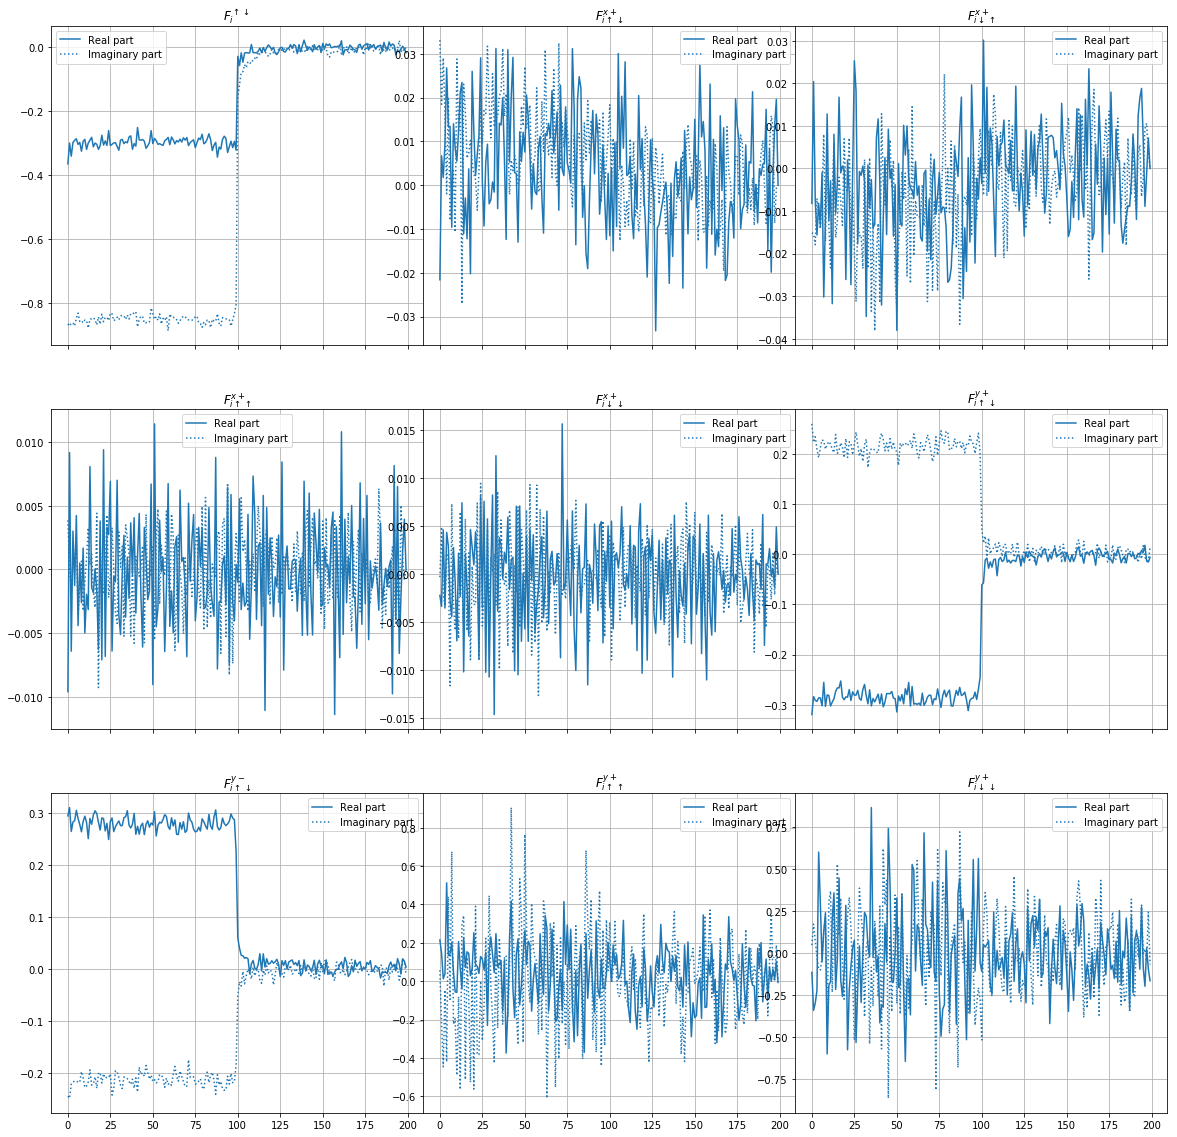

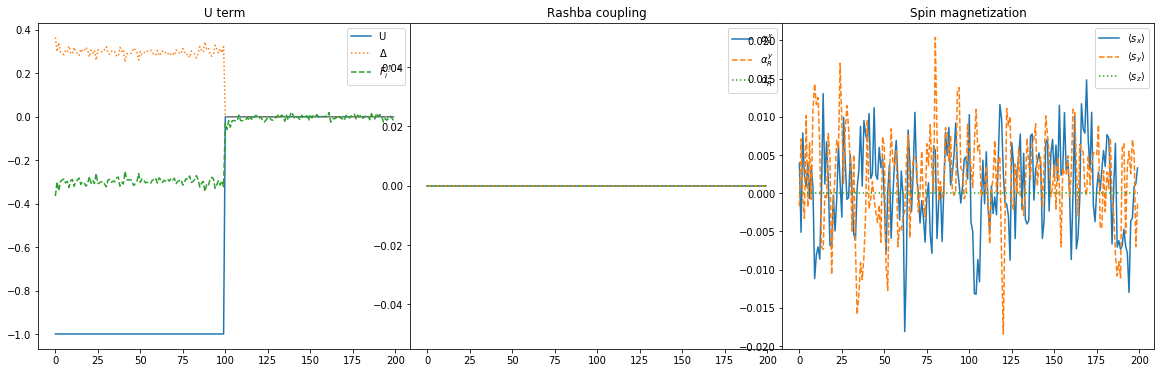

In [135]:
tol = 1e-13
fig = plt.figure(figsize=(20,20))
ax=fig.subplots(ncols=3, nrows=(fres.shape[2]+2)//3, sharex=True, sharey=False).flatten()
for i in range(fres.shape[2]):
    ys = fres[-1, :, i]
    ys[np.abs(ys)< tol] = 0.0 + 0.0j
    complex_plot(y=ys, ax=ax[i], labels=['Real part', 'Imaginary part'])
    ax[i].grid()
    ax[i].legend()
    ax[i].set_title(name_map[i])
fig.subplots_adjust(wspace=0.0)

fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(wspace=0.0)
p.plot(fig)

In [136]:
ldos, es = ldos_from_problem(p, 0.01, 0.03, -4, 4)

Calculating with four loops of size (800, 26, 800, 200). Totaling 3.328e+09 ops.


FileNotFoundError: [Errno 2] No such file or directory: './figures/ldos.pdf'

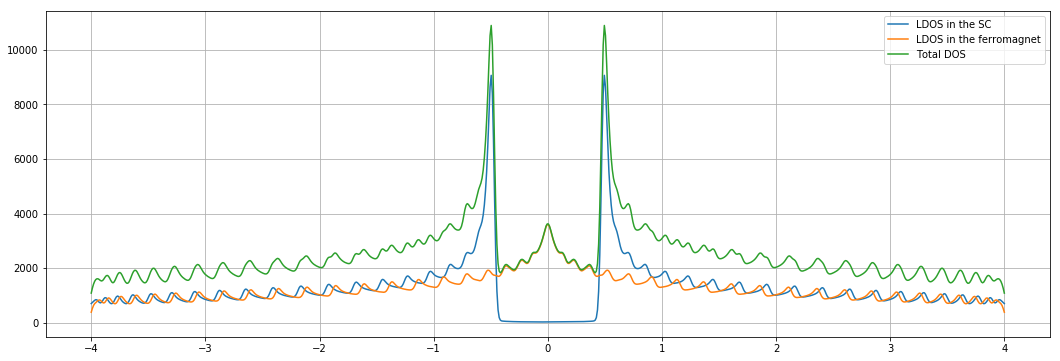

In [137]:
fig = plt.figure(figsize=(18,6))
plt.plot(es, np.sum(ldos[0:100], axis=0), label='LDOS in the SC')
plt.plot(es, np.sum(ldos[100:], axis=0), label='LDOS in the ferromagnet')
plt.plot(es, np.sum(ldos, axis=0), label='Total DOS')
plt.grid()
plt.legend()
fig.savefig('./figures/ldos.pdf')

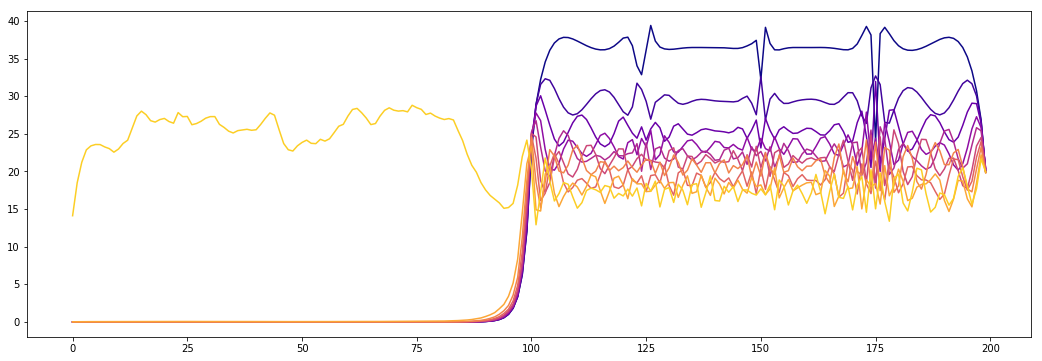

In [138]:
from matplotlib import cm
fig = plt.figure(figsize=(18, 6))
Ne = ldos.shape[1]
step = 5
delta_range = 50
start = Ne//2
stop = min(Ne//2+delta_range, Ne)
for i in range(start, stop, step):
    plt.plot(ldos[:, i], c = cm.plasma(float(i-start)/(stop-start)))

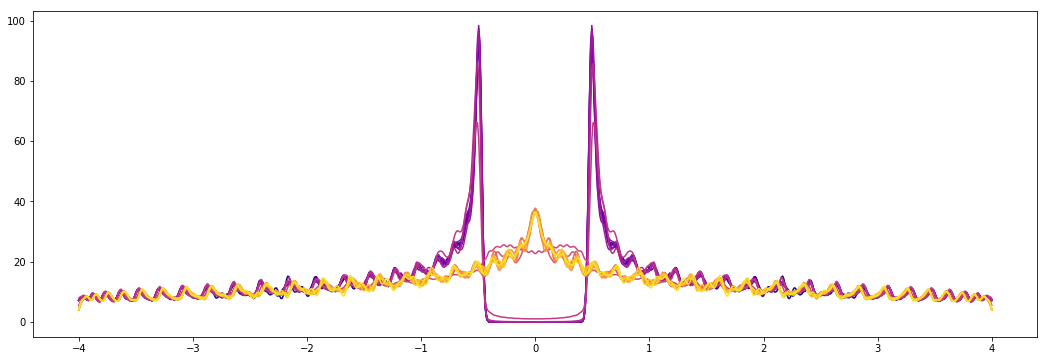

In [139]:
fig, ax = plt.subplots(figsize=(18, 6))
Nx = ldos.shape[0]
step = 5
delta_range = 50
start = max(Nx//2-delta_range, 0)
stop = min(Nx//2+delta_range, Nx)
#stop = Nx//2
for i in range(start, stop, step):
    ax.plot(es, ldos[i, :], c = cm.plasma(float(i-start)/(stop-start)))
#ax.set_xlim()

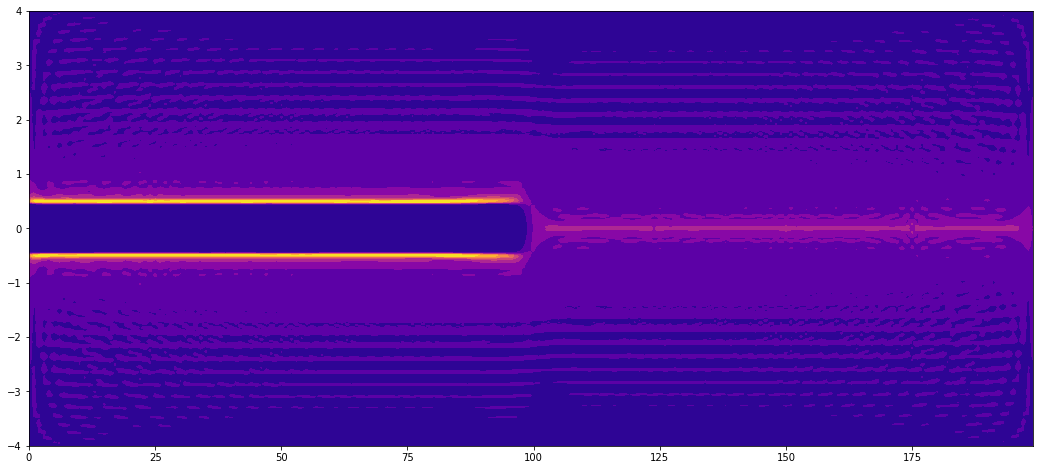

In [140]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.contourf(np.arange(200), es, ldos.T, cmap=cm.plasma, levels=np.linspace(0, 100, 10))